# Local RAG pipeline

In [1]:
import torch
from datetime import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
def showTime():
    return str("["+datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')+" UTC]")

In [4]:
# download pdf
import os
import requests
pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"{showTime()}[INFO] File does not exist, downloading...")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path

    # send request
    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"{showTime()}[INFO] File downloaded and saved as {filename}")
    else:
        print(f"{showTime()}[INFO] Failed to download. {response.status_code}")
else:
    print(f"{showTime()}[INFO] File exists.")    

[2024-10-10 21:34:41.375523 UTC][INFO] File exists.


In [5]:
# open pdf
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor forating on text"""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number-41, # page number where real book content starts
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text)/4, # 1 token = 4 characters
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:3]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -39,
  'page_char_count': 320,
  'page_word_count': 54,
  'page_sentence_count_raw': 1,
  'page_token_count': 80.0,
  'text': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE'}]

In [6]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 598,
  'page_char_count': 1914,
  'page_word_count': 305,
  'page_sentence_count_raw': 12,
  'page_token_count': 478.5,
  'text': 'to excessive sunlight, ozone, smoke, heavy metals, ionizing  radiation, asbestos, and other toxic chemicals increase the amount  of free radicals in the body. They do so by being free radicals  themselves or by adding energy that provokes electrons to move  between atoms. Excessive exposure to environmental sources of  free radicals can contribute to disease by overwhelming the free  radical detoxifying systems and those processes involved in  repairing oxidative damage.  Oxidative Stress  Oxidative stress refers to an imbalance in any cell, tissue, or organ  between the amount of free radicals and the capabilities of the  detoxifying and repair systems. Sustained oxidative damage results  only under conditions of oxidative stress—when the detoxifying and  repair systems are insufficient. Free radical-induced damage, when  left unrepaired, 

In [7]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [8]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


In [9]:
from spacy.lang.en import English

nlp = English()
# https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

# create example document instance
doc = nlp("This is sentence. This id second sentence. I like trains.")
assert len(list(doc.sents)) == 3

list(doc.sents)


[This is sentence., This id second sentence., I like trains.]

In [10]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1045,
  'page_char_count': 308,
  'page_word_count': 53,
  'page_sentence_count_raw': 3,
  'page_token_count': 77.0,
  'text': 'effectively. By contrast, eating a variety of foods from all food groups  fuels the body by providing what it needs to produce energy,  promote metabolic activity, prevent micronutrient deficiencies,  ward off chronic disease, and  bolstering a sense of overall health  and well-being.  Introduction  |  1045',
  'sentences': ['effectively.',
   'By contrast, eating a variety of foods from all food groups  fuels the body by providing what it needs to produce energy,  promote metabolic activity, prevent micronutrient deficiencies,  ward off chronic disease, and  bolstering a sense of overall health  and well-being.',
   ' Introduction  |  1045'],
  'page_sentence_count_spacy': 3}]

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


In [13]:
# chunk sentences together

num_sentence_chunk_size = 10

def split_list(input_list: list[str], slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=1)

[{'page_number': 893,
  'page_char_count': 1061,
  'page_word_count': 219,
  'page_sentence_count_raw': 8,
  'page_token_count': 265.25,
  'text': 'Nutrient  Males, Ages 14–18 Females, Ages 14–18  Vitamin A (mcg)  900.0  700.0  Vitamin B6 (mg)  1.3  1.2  Vitamin B12 (mcg)  2.4  2.4  Vitamin C (mg)  75.0  65.0  Vitamin D (mcg)  5.0  5.0  Vitamin E (mg)  15.0  15.0  Vitamin K (mcg)  75.0  75.0  Calcium (mg)  1,300.0  1,300.0  Folate mcg)  400.0  400.0  Iron (mg)  11.0  15.0  Magnesium (mg)  410.0  360.0  Niacin (B3) (mg)  16.0  14.0  Phosphorus (mg)  1,250.0  1,250.0  Riboflavin (B2) (mg) 1.3  1.0  Selenium (mcg)  55.0  55.0  Thiamine (B1) (mg)  1.2  1.0  Zinc (mg)  11.0  9.0  Source: Institute of Medicine. 2006. Dietary Reference Intakes: The  Essential Guide to Nutrient Requirements. Washington, DC: The  National Academies Press. https://doi.org/10.17226/11537. Accessed  December 10, 2017.  Eating Disorders  Many teens struggle with an eating disorder, which can have a  detrimental eff

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


In [17]:
# spliting each chunk into each own item

import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        # join list of sentences into paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        # add " " before start of sentece and after .
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)
        
        

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [18]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 974,
  'sentence_chunk': '“Heat Index” by National Weather Service, Southern Region Headquarter s / Public Domain Hyponatremia Sweating during exercise helps our bodies to stay cool. Sweat consists of mostly water but it also causes losses of sodium, potassium, calcium and magnesium. During most exercises, the amount of sodium lost is very small. Drinking water after completing an exercise will replenish the sodium in the body. However, during long endurance exercises such as a marathon or triathlon, sodium losses are larger and must be replenished as well. If water is replenished without sodium the sodium already in the body will become diluted. These low levels of sodium in the blood will cause a condition known as hyponatremia (see Figure 16.11 “The Effect of Exercise on Sodium Levels”). When sodium levels in the blood are decreased, water moves into the cell through osmosis which causes swelling. Accumulation of fluid in the lungs and the brain can cause serious li

In [19]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


In [20]:
# filter chunks of text for short chunks
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count: 10.5 | Text: You can view it online here: Calcium | 629
Chunk token count: 19.5 | Text: Honor your health – gentle nutrition    Calories In Versus Calories Out | 1075
Chunk token count: 12.5 | Text: https://www.fda.gov/food/ 1022 | Food Preservation
Chunk token count: 12.0 | Text: PART V CHAPTER 5. LIPIDS Chapter 5. Lipids | 289
Chunk token count: 16.25 | Text: Complementary foods include baby meats, vegetables, Infancy | 837


In [21]:
# filter dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [22]:
random.sample(pages_and_chunks_over_min_token_len, k=2)

[{'page_number': 232,
  'sentence_chunk': 'The monosaccharide galactose differs from glucose only in that a hydroxyl (−OH) group faces in a different direction on the number four carbon (Figure 4.2 “Structures of the Three Most Common Monosaccharides: Glucose, Galactose, and Fructose”). This small structural alteration causes galactose to be less stable than glucose. As a result, the liver rapidly converts it to glucose. Most absorbed galactose is utilized for energy production in cells after its conversion to glucose. (Galactose is one of two simple sugars that 232 | Introduction',
  'chunk_char_count': 544,
  'chunk_word_count': 84,
  'chunk_token_count': 136.0},
 {'page_number': 894,
  'sentence_chunk': 'worldwide.3 These disorders are more prevalent among adolescent girls, but have been increasing among adolescent boys in recent years. Because eating disorders often lead to malnourishment, adolescents with an eating disorder are deprived of the crucial nutrients their still-growing

In [23]:
# embeding text chunks
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

sentences = ["Sentence Transformers  is the go-to Python module for accessing, using, and training state-of-the-art text and image embedding models.",
             "It can be used to compute embeddings using Sentence Transformer models.",
             "Or to calculate similarity scores using Cross-Encoder models (quickstart).",
             "I like oranges!"
            ]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence} | Embedding: {embedding}")

F:\OneDrive\github\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
F:\OneDrive\github\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: Sentence Transformers  is the go-to Python module for accessing, using, and training state-of-the-art text and image embedding models. | Embedding: [ 5.34216687e-02  2.65813842e-02 -4.48918482e-03  5.93200512e-02
 -2.61534285e-02  1.94523521e-02  5.60242543e-03 -2.80467956e-03
  8.21539573e-03 -8.18702057e-02  1.94471120e-03  6.86734496e-03
 -2.91680321e-02  4.43347171e-02  6.03051204e-03 -1.03364438e-01
  7.97539111e-03  7.63178628e-04  1.06992887e-03  3.44491303e-02
  3.61879170e-02  1.65099427e-02  1.89586747e-02  7.07316101e-02
 -4.80418317e-02 -1.90921985e-02  2.15894151e-02  2.40902938e-02
  4.91196616e-03 -7.31106009e-03  1.90134346e-02  1.89336725e-02
  5.87720945e-02  7.21790036e-03  1.62987783e-06  4.75013442e-02
  1.77877303e-02 -1.53129799e-02  2.65215486e-02  9.36527364e-03
  9.98330638e-02 -7.21652582e-02  1.59420054e-02  1.77639723e-02
 -3.04701831e-02  1.50883812e-02  4.88863066e-02  8.50658417e-02
  7.33739659e-02  8.73203278e-02 -2.37938538e-02 -2.61304732e-

In [24]:
embeddings[0].shape

(768,)

In [25]:
embedding = embedding_model.encode("I like trains.")
embedding

array([-6.61777407e-02,  1.08034439e-01, -1.73398517e-02,  2.59081796e-02,
        1.68851223e-02,  3.35716531e-02, -2.45636888e-02, -1.88797992e-02,
       -4.09865156e-02, -1.09141804e-02,  5.84466010e-03,  4.02872497e-03,
       -6.20981157e-02, -4.92319465e-02,  2.45086267e-03, -6.47033751e-02,
        3.94016244e-02, -2.31145285e-02, -1.03348777e-01,  3.15237306e-02,
        2.37877923e-03,  4.83119935e-02, -4.25290577e-02, -1.39789656e-02,
       -2.20304728e-02,  3.79067753e-03, -2.42629256e-02, -6.35410175e-02,
        3.40222046e-02,  4.36703116e-02, -1.78661961e-02,  5.34686213e-03,
        3.54878651e-03,  3.20020095e-02,  1.59164517e-06,  4.62644622e-02,
       -3.53364311e-02,  1.27375694e-02,  2.53395680e-02, -2.91919559e-02,
        4.92486767e-02, -6.11238088e-03, -9.67751537e-03, -2.03889981e-02,
       -2.21629092e-03, -1.74699593e-02,  5.17543368e-02,  3.11498214e-02,
       -8.40535574e-03,  3.38792019e-02, -1.15190363e-02, -2.02138815e-02,
       -1.07733719e-01, -

In [26]:
%%time
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 3min 30s
Wall time: 38 s


In [27]:
%%time
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[100]

CPU times: total: 0 ns
Wall time: 0 ns


'Nutrition Assessment Nutritional assessment is the interpretation of anthropometric, biochemical (laboratory), clinical and dietary data to determine whether a person or groups of people are well nourished or malnourished (overnourished or undernourished). Nutritional assessment can be done using the ABCD methods. These refer to the following: • A. Anthropometry • B. Biochemical methods • C. Clinical methods • D. Dietary methods Anthropometry methods of assessing nutritional status The word anthropometry comes from two words: Anthropo means ‘human’ and metry means ‘measurement’. The different measurements taken to assess growth and body composition are presented below. To assess growth, several different measurements including length, height, weight, head circumference, mid-arm circumference, skin-fold thickness, head/chest ratio, and hip/waist ratio can be used. Height and weight measurements are essential in children to evaluate physical growth. As an additional resource, the NHANES

In [28]:
%%time
# embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=16, convert_to_tensor=True)
text_chunk_embeddings[100]

CPU times: total: 1min 28s
Wall time: 17.5 s


tensor([ 1.2773e-02, -1.0473e-02,  7.8695e-03, -3.4675e-03,  9.6361e-05,
        -3.3710e-03,  1.4906e-02,  1.1292e-02,  3.0318e-02, -9.5284e-03,
         8.3516e-02, -1.0757e-01,  6.2119e-02, -8.9779e-03, -9.7639e-03,
        -1.9894e-03, -1.8487e-02, -1.7352e-02, -2.0593e-02,  6.3473e-02,
        -6.6939e-02, -4.7820e-03, -9.5209e-03, -1.8517e-02, -4.3938e-02,
         4.6283e-02,  3.2606e-02, -2.0607e-02, -1.8851e-02, -5.1422e-02,
         1.2133e-02, -9.4620e-03, -1.3889e-02, -3.8846e-02,  1.9150e-06,
        -4.6082e-02,  1.8463e-02,  2.5674e-02, -1.9828e-02,  2.2107e-02,
         7.4989e-02, -5.6563e-02, -1.7632e-02, -3.8679e-02,  7.9016e-03,
        -8.7244e-03,  5.5975e-02,  3.4743e-04, -3.4352e-02, -1.5650e-02,
         2.4092e-02, -5.0074e-02, -3.4213e-02, -1.2408e-02, -1.0899e-02,
         3.7432e-02, -2.4751e-03,  7.9598e-02,  5.9286e-02,  3.9348e-02,
        -1.1415e-02,  4.3283e-02,  3.8863e-02,  2.4163e-02, -1.1961e-02,
        -2.1793e-03, -6.3283e-03, -4.6967e-02,  5.4

In [29]:
# save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [30]:
# import saved embeddings
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242899e-02 9.02281404e-02 -5.09547861e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139252e-02 -1.66167393e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801823e-02 3.39813717e-02 -2.06426494e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566985e-02 3.81274670e-02 -8.46854597e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49768054e-03 9.57159698e-...


In [31]:
###similarity search

import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# convert embedding column back to numpy array
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# convert embedings into torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].to_list(), axis=0), dtype=torch.float32).to(device)

# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

cuda


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242899, 0.0902281404, -0.00509547861, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139252, -0.0166167393, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801823, 0.0339813717, -0.0206426494, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566985, 0.038127467, -0.00846854597, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.00849768054, 0.00957159698, ..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1304,186,326.00,"[0.0185622536, -0.0164277833, -0.0127045522, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.0334720351, -0.0570440404, 0.0151489126, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,"[0.0770515651, 0.00978558976, -0.012181744, 0...."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045143, -0.0164702013, 0.00826846808, 0...."


In [32]:
text_chunks_and_embeddings_df["embedding"]

0       [0.0674242899, 0.0902281404, -0.00509547861, -...
1       [0.0552156419, 0.0592139252, -0.0166167393, -0...
2       [0.0279801823, 0.0339813717, -0.0206426494, 0....
3       [0.0682566985, 0.038127467, -0.00846854597, -0...
4       [0.0330264494, -0.00849768054, 0.00957159698, ...
                              ...                        
1675    [0.0185622536, -0.0164277833, -0.0127045522, -...
1676    [0.0334720351, -0.0570440404, 0.0151489126, -0...
1677    [0.0770515651, 0.00978558976, -0.012181744, 0....
1678    [0.103045143, -0.0164702013, 0.00826846808, 0....
1679    [0.0863774046, -0.0125358906, -0.0112746535, 0...
Name: embedding, Length: 1680, dtype: object

In [33]:
embeddings.shape

torch.Size([1680, 768])

In [34]:
# create model
from sentence_transformers import  util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)


F:\OneDrive\github\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
# define query
query = "good source for proteins"
print(f"Query: {query}")

# embed query with the same model
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# get similarity scores with dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"{showTime()}[INFO] Time to get a score on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

# get top-k results k=5
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: good source for proteins
[2024-10-10 21:36:01.759427 UTC][INFO] Time to get a score on 1680 embeddings: 0.00015 seconds


torch.return_types.topk(
values=tensor([0.7230, 0.7153, 0.6933, 0.6835, 0.6817], device='cuda:0'),
indices=tensor([611, 616, 620, 618, 617], device='cuda:0'))

In [36]:
larger_embeddings = torch.randn(10*embeddings.shape[0], 768).to(device)
print(f"{showTime()}[INFO] Embeddings shape {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()
print(f"{showTime()}[INFO] Time to get a score on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds")

[2024-10-10 21:36:01.836196 UTC][INFO] Embeddings shape torch.Size([16800, 768])
[2024-10-10 21:36:01.837196 UTC][INFO] Time to get a score on 16800 embeddings: 0.00036 seconds


In [37]:
torch.cuda.empty_cache() 

In [38]:
#embeddings[42]

In [39]:
#pages_and_chunks[42]

In [40]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [41]:
print(f"{showTime()} Query: {query}\n")
print(f"{showTime()} Results: ")
pages_with_results = []
# loop through zipped scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print(f"Text: ")
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")
    pages_with_results.append(pages_and_chunks[idx]['page_number'])
print(pages_with_results[0])

[2024-10-10 21:36:01.862430 UTC] Query: good source for proteins

[2024-10-10 21:36:01.863431 UTC] Results: 
Score: 0.7230
Text: 
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411


Score: 0.7153
Text: 
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, a

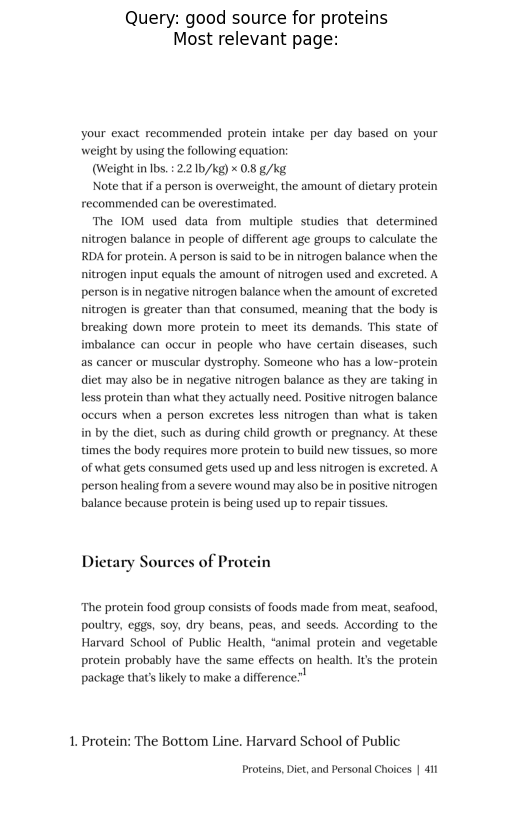

In [42]:
# automatically open pdf page related to query
import fitz

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(pages_with_results[0] + 41)

# get image of page
img = page.get_pixmap(dpi=300)

# save image
img.save("output_filename.png")
doc.close()

# convert pixmap into numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# display image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} \nMost relevant page: ")
plt.axis("off")
plt.show()


In [43]:
# functionizing semantic search pipeline

def retrieve_relevant_resources(query: str, 
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds query with model and returns top-k scores and indexes from embeddings
    """

    # embed query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"{showTime()}[INFO] Time to get a score on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices


def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Find reveleant pasages in query and print them out along with their resources
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)

    pages_with_results = []
    # loop through zipped scores and indicies from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print(f"Text: ")
        print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")
        pages_with_results.append(pages_and_chunks[idx]['page_number'])
                                

In [44]:
retrieve_relevant_resources(query="food high in protein", embeddings=embeddings)

[2024-10-10 21:36:02.603274 UTC][INFO] Time to get a score on 1680 embeddings: 0.00006 seconds


(tensor([0.7730, 0.7405, 0.7025, 0.7016, 0.6930], device='cuda:0'),
 tensor([611, 616, 612, 617, 620], device='cuda:0'))

In [45]:
print_top_results_and_scores(query="food high in protein", embeddings=embeddings)

[2024-10-10 21:36:02.621661 UTC][INFO] Time to get a score on 1680 embeddings: 0.00005 seconds
Score: 0.7730
Text: 
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411


Score: 0.7405
Text: 
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean 

In [46]:
# getting llm for local generation
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"{showTime()}[INFO] Available GPU memory {gpu_memory_gb} GB")

[2024-10-10 21:36:02.629611 UTC][INFO] Available GPU memory 12 GB


In [47]:
!nvidia-smi

Thu Oct 10 21:36:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:07:00.0  On |                  N/A |
|  0%   50C    P3               24W / 100W|   3296MiB / 12288MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [48]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}") 

GPU memory: 12 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [49]:
from huggingface_hub import notebook_login
notebook_login()

In [50]:
# load llm locally
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                            bnb_4bit_compute_dtype=torch.float16)

if(is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scalled dot product attention
print(f"{showTime()}[INFO] Using flash attention implementation: {attn_implementation}")

# pick model
model_id = model_id

# instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# instantiate model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                  torch_dtype=torch.float16,
                                  quantization_config=quantization_config if use_quantization_config else None,
                                  low_cpu_mem_usage=False,
                                  attn_implementation=attn_implementation)
if not use_quantization_config:
    llm_model.to("cuda")
    

[2024-10-10 21:36:02.865208 UTC][INFO] Using flash attention implementation: sdpa


F:\OneDrive\github\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
!nvidia-smi

Thu Oct 10 21:36:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:07:00.0  On |                  N/A |
|  0%   50C    P5               17W / 100W|   8211MiB / 12288MiB |     45%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [52]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [53]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [54]:
def get_model_mem_size(model: torch.nn.Module):
    # get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.parameters()])
    # calculate model size
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 3)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 10024689664,
 'model_mem_mb': 9560.29,
 'model_mem_gb': 9.336}

In [56]:
# generate text with llm
input_text = "What are macronutrients, what role do they play in human body?"

# create prompt template for instruction tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# apply chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
print(f"{showTime()}[INFO] Prompt (formatted): \n{prompt}")

[2024-10-10 22:11:10.843940 UTC][INFO] Prompt (formatted): 
<bos><start_of_turn>user
What are macronutrients, what role do they play in human body?<end_of_turn>
<start_of_turn>model



In [58]:
%%time

# tokenize input text and send to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
input_ids

CPU times: total: 0 ns
Wall time: 31.1 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708, 186809, 184592,
         235269,   1212,   4731,    749,    984,   1554,    575,   3515,   2971,
         235336,    107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [61]:
%%time
# generate output from local LLM
outputs = llm_model.generate(**input_ids, max_new_tokens=256)
print(f"{showTime()}[INFO] Model output (tokens): \n{outputs[0]}\n")

[2024-10-10 22:23:39.951218 UTC][INFO] Model output (tokens): 
tensor([     2,      2,    106,   1645,    108,   1841,    708, 186809, 184592,
        235269,   1212,   4731,    749,    984,   1554,    575,   3515,   2971,
        235336,    107,    108,    106,   2516,    108,  21404, 235269,   1517,
        235303, 235256,    476,  11352,  15844,    576, 186809, 184592, 235292,
           109,    688,  12298,   1695, 184592,    688,    708,  37132,    674,
           573,   2971,   4026,    575,   2910,  15992,    577,  10528,   1426,
          2962, 235265,   2365,    708,  13538,   1280,   1378,   1872,  14486,
        235292, 186809, 184592,    578,  92800, 184592, 235265,    109,    688,
         12298,   1695, 184592,    688,    708,  37132,    674,    573,   2971,
          4026,    575,   8107,  15992,   1178,  92800, 184592, 235265,   2365,
           708,  13538,   1280,   2149,  14486, 235292,    109, 235287,   5231,
        156615,  56227,    688,   3658,   4134,    604,  

In [62]:
# decode output to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"{showTime()}[INFO] Model output (decoded): \n{outputs_decoded}\n")

[2024-10-10 22:25:01.564602 UTC][INFO] Model output (decoded): 
<bos><bos><start_of_turn>user
What are macronutrients, what role do they play in human body?<end_of_turn>
<start_of_turn>model
Sure, here's a detailed explanation of macronutrients:

**Macronutrients** are nutrients that the body needs in large amounts to maintain good health. They are divided into two main categories: macronutrients and micronutrients.

**Macronutrients** are nutrients that the body needs in larger amounts than micronutrients. They are divided into three categories:

* **Carbohydrates** provide energy for the body's cells and tissues.
* **Protein** is essential for building and repairing tissues, making enzymes, and producing hormones.
* **Fat** helps to absorb fat-soluble vitamins, insulate the body, and provide energy.

**Micronutrients** are nutrients that the body needs in smaller amounts than macronutrients. They are divided into two categories:

* **Minerals** are needed for many bodily functions, i

In [63]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [65]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What is the RDI for protein per day?
[2024-10-10 22:30:36.218756 UTC][INFO] Time to get a score on 1680 embeddings: 0.00017 seconds


(tensor([0.6793, 0.6771, 0.6418, 0.6109, 0.5908], device='cuda:0'),
 tensor([ 609,  607, 1007,  608, 1005], device='cuda:0'))

In [100]:
# augumenting prompt with context items
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    
    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# get relevant resources
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

# create list of context items
context_items = [pages_and_chunks[i] for i in indices]

# format prompt
prompt = prompt_formatter(query=query, context_items=context_items)

print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
[2024-10-11 01:05:10.513557 UTC][INFO] Time to get a score on 1680 embeddings: 0.00012 seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protectin

In [101]:
%%time
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# generate output of tokens
outputs = llm_model.generate(**input_ids, temperature=0.7, do_sample=True, max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])
print(f"Query: \n{query}")
print(f"RAG answer: \n{output_text.replace(prompt, '')}")

Query: 
Explain the concept of energy balance and its importance in weight management.
RAG answer: 
<bos>Sure, here's the relevant passage from the context that explains the concept of energy balance and its importance in weight management:

> Weight can be thought of as a whole body estimate of energy balance; body weight is maintained when the body is in energy balance, lost when it is in negative energy balance, and gained when it is in positive energy balance.<eos>
CPU times: total: 4.23 s
Wall time: 4.5 s
